# A Simple Convertible Bond

**What is a Convertible Bond?**

A **convertible bond** is a loan you make to a company that comes with a special option: you can swap it for company stock if you want.

The bond holder recieves(debt):
- Regular interest (coupon payments) from the issuer (the company)
- At maturity, the par value of the bond is returned

**The conversion option:**
The bond can be converted into a fixed number of shares of the company, e.g (1 bond → 1 share of stock). This choice can be exercises at any point (or at maturity), but the decision is when to make this choice and if it is correct. Considerations:

1. **Keep it as a bond** → Get your $100 back + coupons (safer, predictable)
2. **Convert to stock** → Get shares worth whatever the stock price is (risky, but unlimited upside)

- If the stock price is **$150**, converting gives the holder $150 worth of stock (better than $100 cash) → **Convert!**
- If the stock price is **$50**, converting gives the holder $50 worth of stock (worse than $100 cash) → **Don't convert!**

- The company pays **lower interest** than regular bonds because you get the conversion option as compensation which enables a way to potentially sell stock later at a higher price



#### Parameters for this convertible bond can be defined using the following parameters

The ones below have been taken directly from Goldman Sachs Quant Strats (Valuing Convertible Bonds Document)

In [15]:
# Parameters for convertible bond pricing model
p = 100
coupon_rate = 0.05
maturity = 10

# calls = None
# puts = None

vol = 0.2 
risk_less_rate = 0.05
stock_loan_rate = 0.05
dividend_yield = 0.02
credit_spread = 0.01 # 100 basis points
S0 = 100
conversion_ratio = 1.0
n_steps = 5

In [12]:
import numpy as np
import pandas as pd
from plotnine import *

In [16]:
# CRR tree parameters
dt = maturity / n_steps
u = np.exp(vol * np.sqrt(dt))  # up factor
d = 1/u  # down factor
q = (np.exp((risk_less_rate - dividend_yield) * dt) - d) / (u - d)

print(f"Up factor (u): {u:.4f}")
print(f"Down factor (d): {d:.4f}")
print(f"Risk-neutral probability (q): {q:.4f}")

# Build stock price tree
stock_tree = np.zeros((n_steps + 1, n_steps + 1))
for i in range(n_steps + 1):
    for j in range(i + 1):
        stock_tree[j, i] = S0 * (u ** (i - j)) * (d ** j)

Up factor (u): 1.3269
Down factor (d): 0.7536
Risk-neutral probability (q): 0.5376


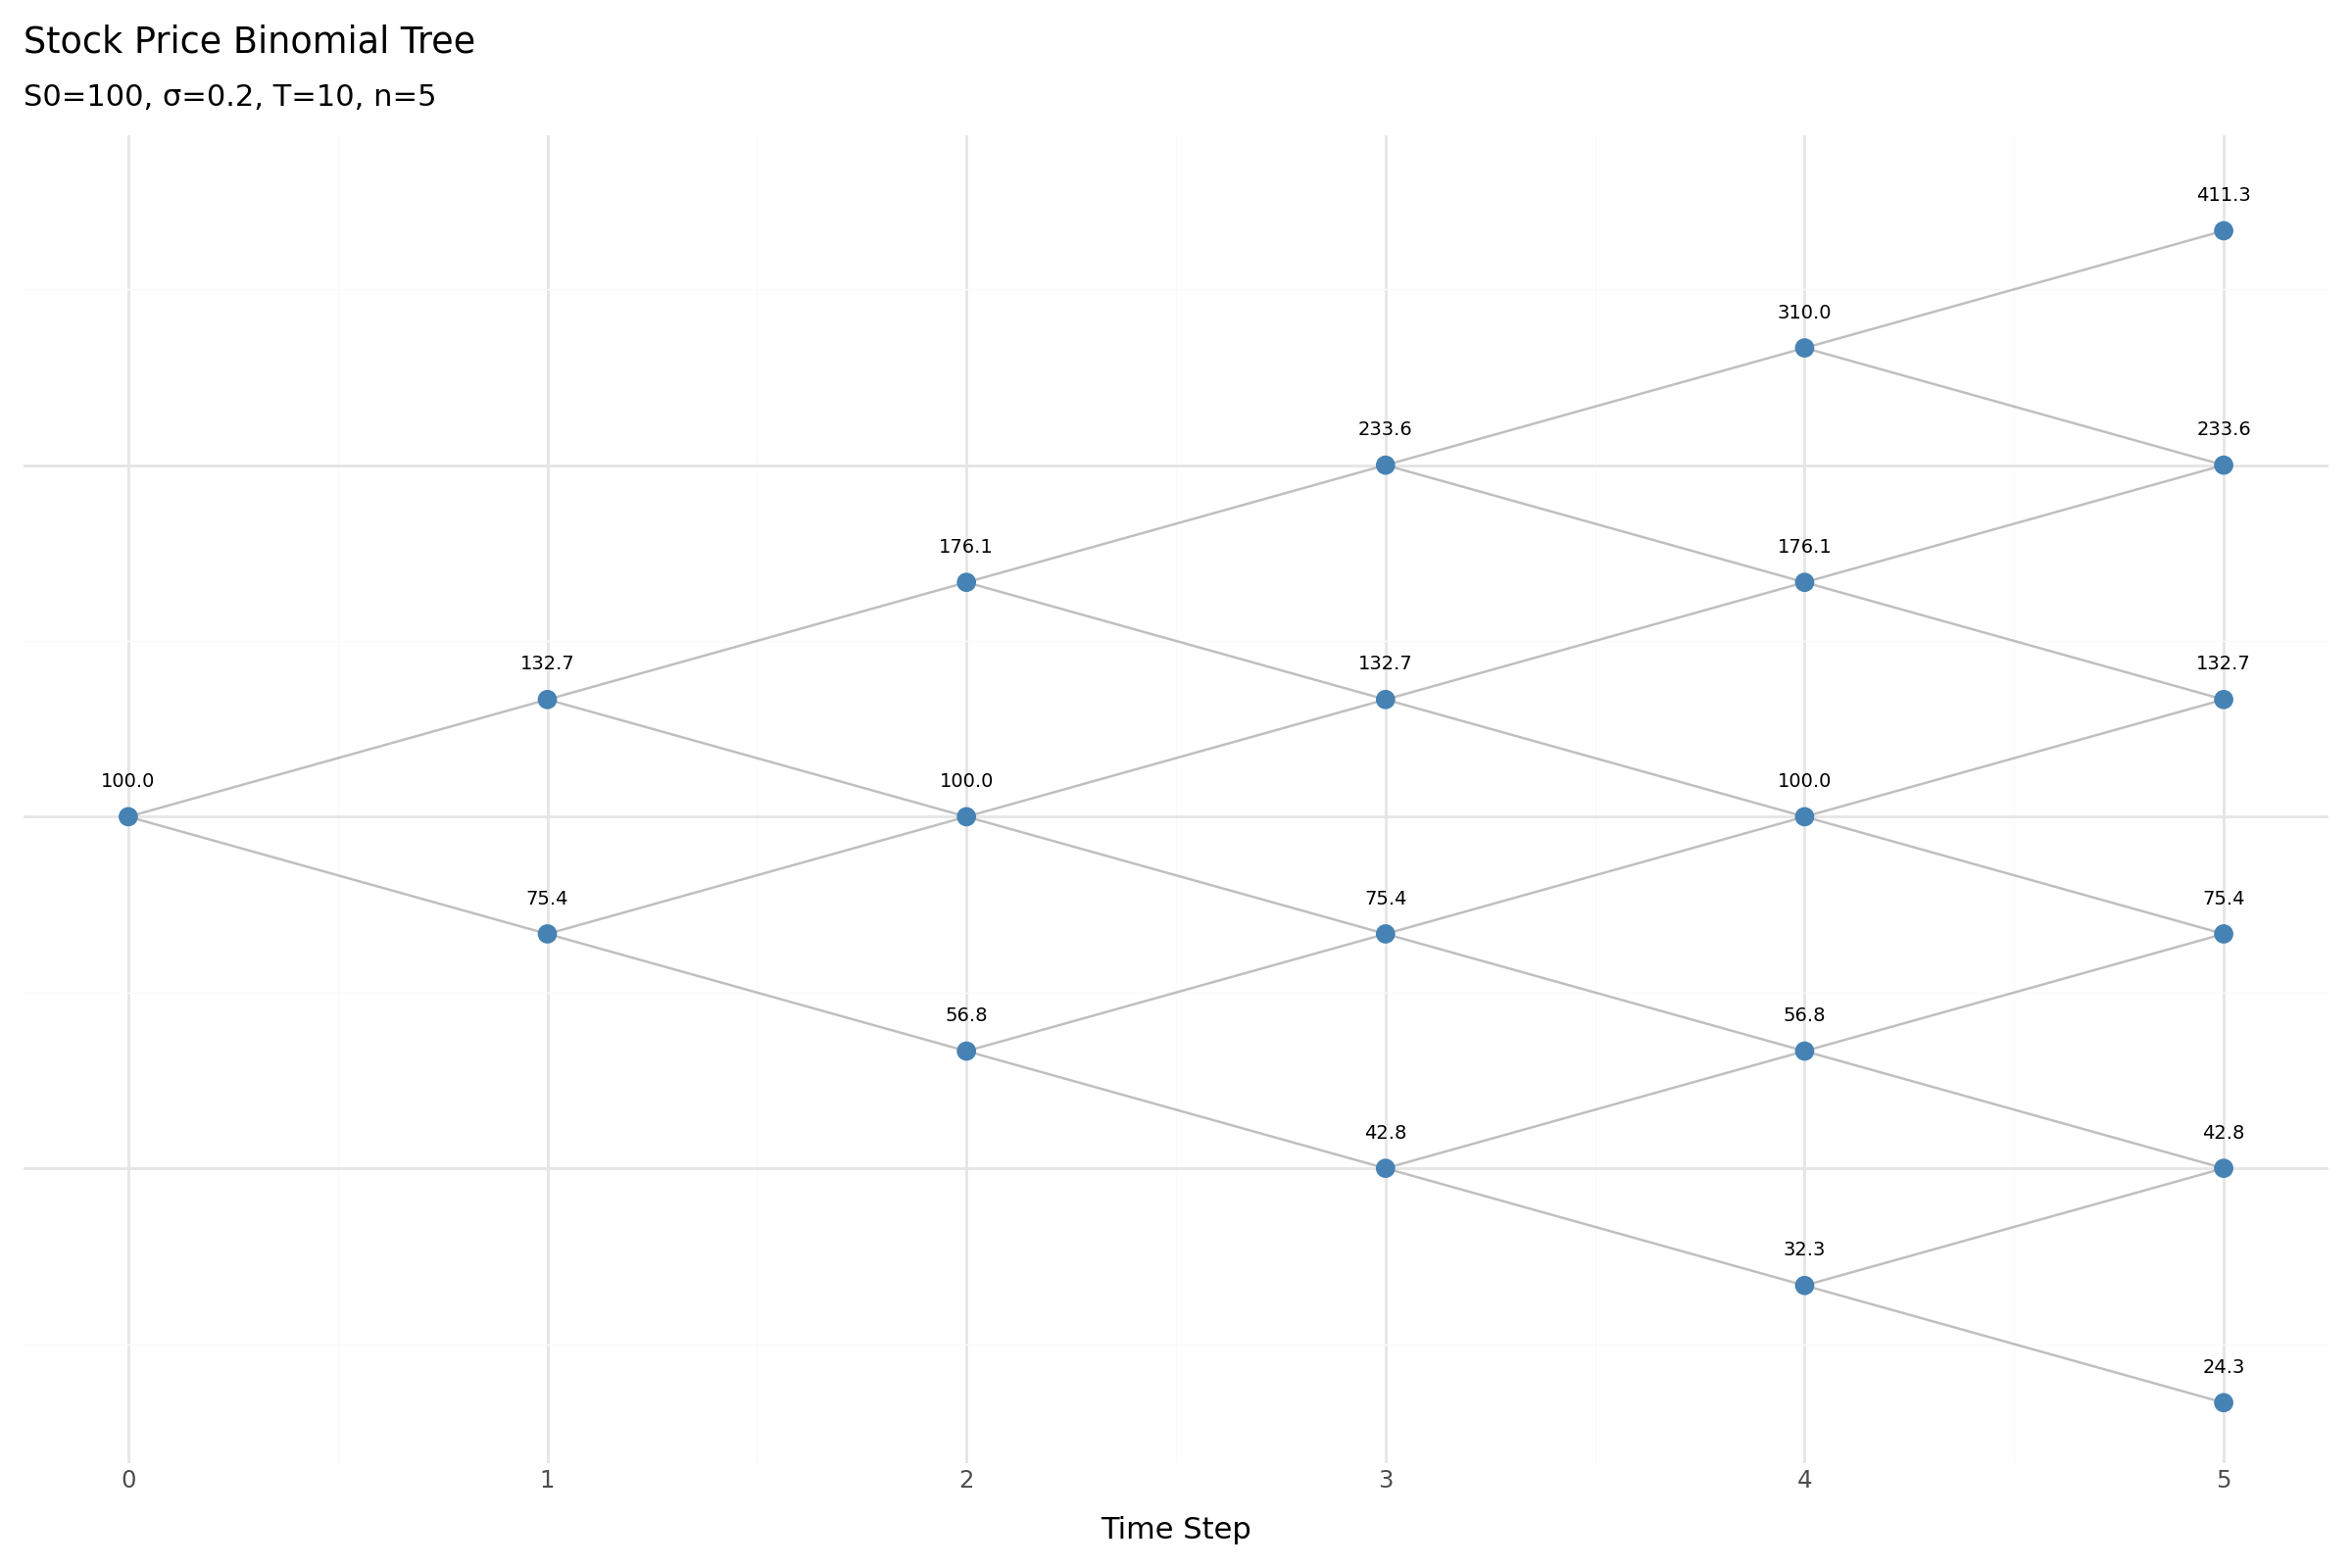

In [17]:
# Convert tree to dataframe for plotting
tree_data = []
for i in range(n_steps + 1):
    for j in range(i + 1):
        tree_data.append({
            'time': i,
            'node': j,
            'price': stock_tree[j, i],
            'y_pos': i - 2*j
        })
df_tree = pd.DataFrame(tree_data)

# Create edges for the tree
edges = []
for i in range(n_steps):
    for j in range(i + 1):
        edges.append({'x': i, 'y': i - 2*j, 'xend': i + 1, 'yend': (i + 1) - 2*j, 'type': 'up'})
        edges.append({'x': i, 'y': i - 2*j, 'xend': i + 1, 'yend': (i + 1) - 2*(j + 1), 'type': 'down'})
df_edges = pd.DataFrame(edges)

# Create the plot
plot = (
    ggplot() +
    geom_segment(data=df_edges, mapping=aes(x='x', y='y', xend='xend', yend='yend'), color='gray', alpha=0.5) +
    geom_point(data=df_tree, mapping=aes(x='time', y='y_pos'), size=3, color='steelblue') +
    geom_text(data=df_tree, mapping=aes(x='time', y='y_pos', label='price'), format_string='{:.1f}', size=7, nudge_y=0.3) +
    labs(title='Stock Price Binomial Tree', x='Time Step', y='', subtitle=f'S0={S0}, σ={vol}, T={maturity}, n={n_steps}') +
    theme_minimal() +
    theme(axis_text_y=element_blank(), axis_ticks_y=element_blank(), figure_size=(12, 8))
)

plot

In [23]:
bond_value = np.zeros((n_steps + 1, n_steps + 1))
conversion_prob = np.zeros((n_steps + 1, n_steps + 1))
discount_rate_tree = np.zeros((n_steps + 1, n_steps + 1))

# Initialize at maturity
for j in range(n_steps + 1):
    conversion_value = stock_tree[j, n_steps] * conversion_ratio
    redemption_value = p
    bond_value[j, n_steps] = max(conversion_value, redemption_value)
    conversion_prob[j, n_steps] = 1.0 if conversion_value > redemption_value else 0.0

# Work backwards through the tree
coupon_payment = p * coupon_rate * dt

for i in range(n_steps - 1, -1, -1):
    for j in range(i + 1):
        prob_up = conversion_prob[j, i + 1]
        prob_down = conversion_prob[j + 1, i + 1]
        conv_prob = q * prob_up + (1 - q) * prob_down
        
        discount_rate = risk_less_rate + credit_spread * (1 - conv_prob)
        discount_rate_tree[j, i] = discount_rate
        discount_factor = np.exp(-discount_rate * dt)
        
        expected_value = q * bond_value[j, i + 1] + (1 - q) * bond_value[j + 1, i + 1]
        holding_value = (expected_value + coupon_payment) * discount_factor
        
        conversion_value = stock_tree[j, i] * conversion_ratio
        
        bond_value[j, i] = max(holding_value, conversion_value)
        
        if conversion_value > holding_value:
            conversion_prob[j, i] = 1.0
        else:
            conversion_prob[j, i] = conv_prob


In [25]:
# Create comprehensive dataframe
tree_data = []
for i in range(n_steps + 1):
    for j in range(i + 1):
        tree_data.append({
            'time': i,
            'node': j,
            'y_pos': i - 2*j,
            'stock_price': stock_tree[j, i],
            'bond_value': bond_value[j, i],
            'conv_prob': conversion_prob[j, i],
            'discount_rate': discount_rate_tree[j, i] if i < n_steps else np.nan
        })

df_tree = pd.DataFrame(tree_data)

# Create edges
edges = []
for i in range(n_steps):
    for j in range(i + 1):
        edges.append({'x': i, 'y': i - 2*j, 'xend': i + 1, 'yend': (i + 1) - 2*j})
        edges.append({'x': i, 'y': i - 2*j, 'xend': i + 1, 'yend': (i + 1) - 2*(j + 1)})
df_edges = pd.DataFrame(edges)

# Create labels combining stock and bond info
df_tree['label'] = df_tree.apply(
    lambda row: f"S:{row['stock_price']:.1f}\nB:{row['bond_value']:.1f}\nP:{row['conv_prob']:.2f}", 
    axis=1
)

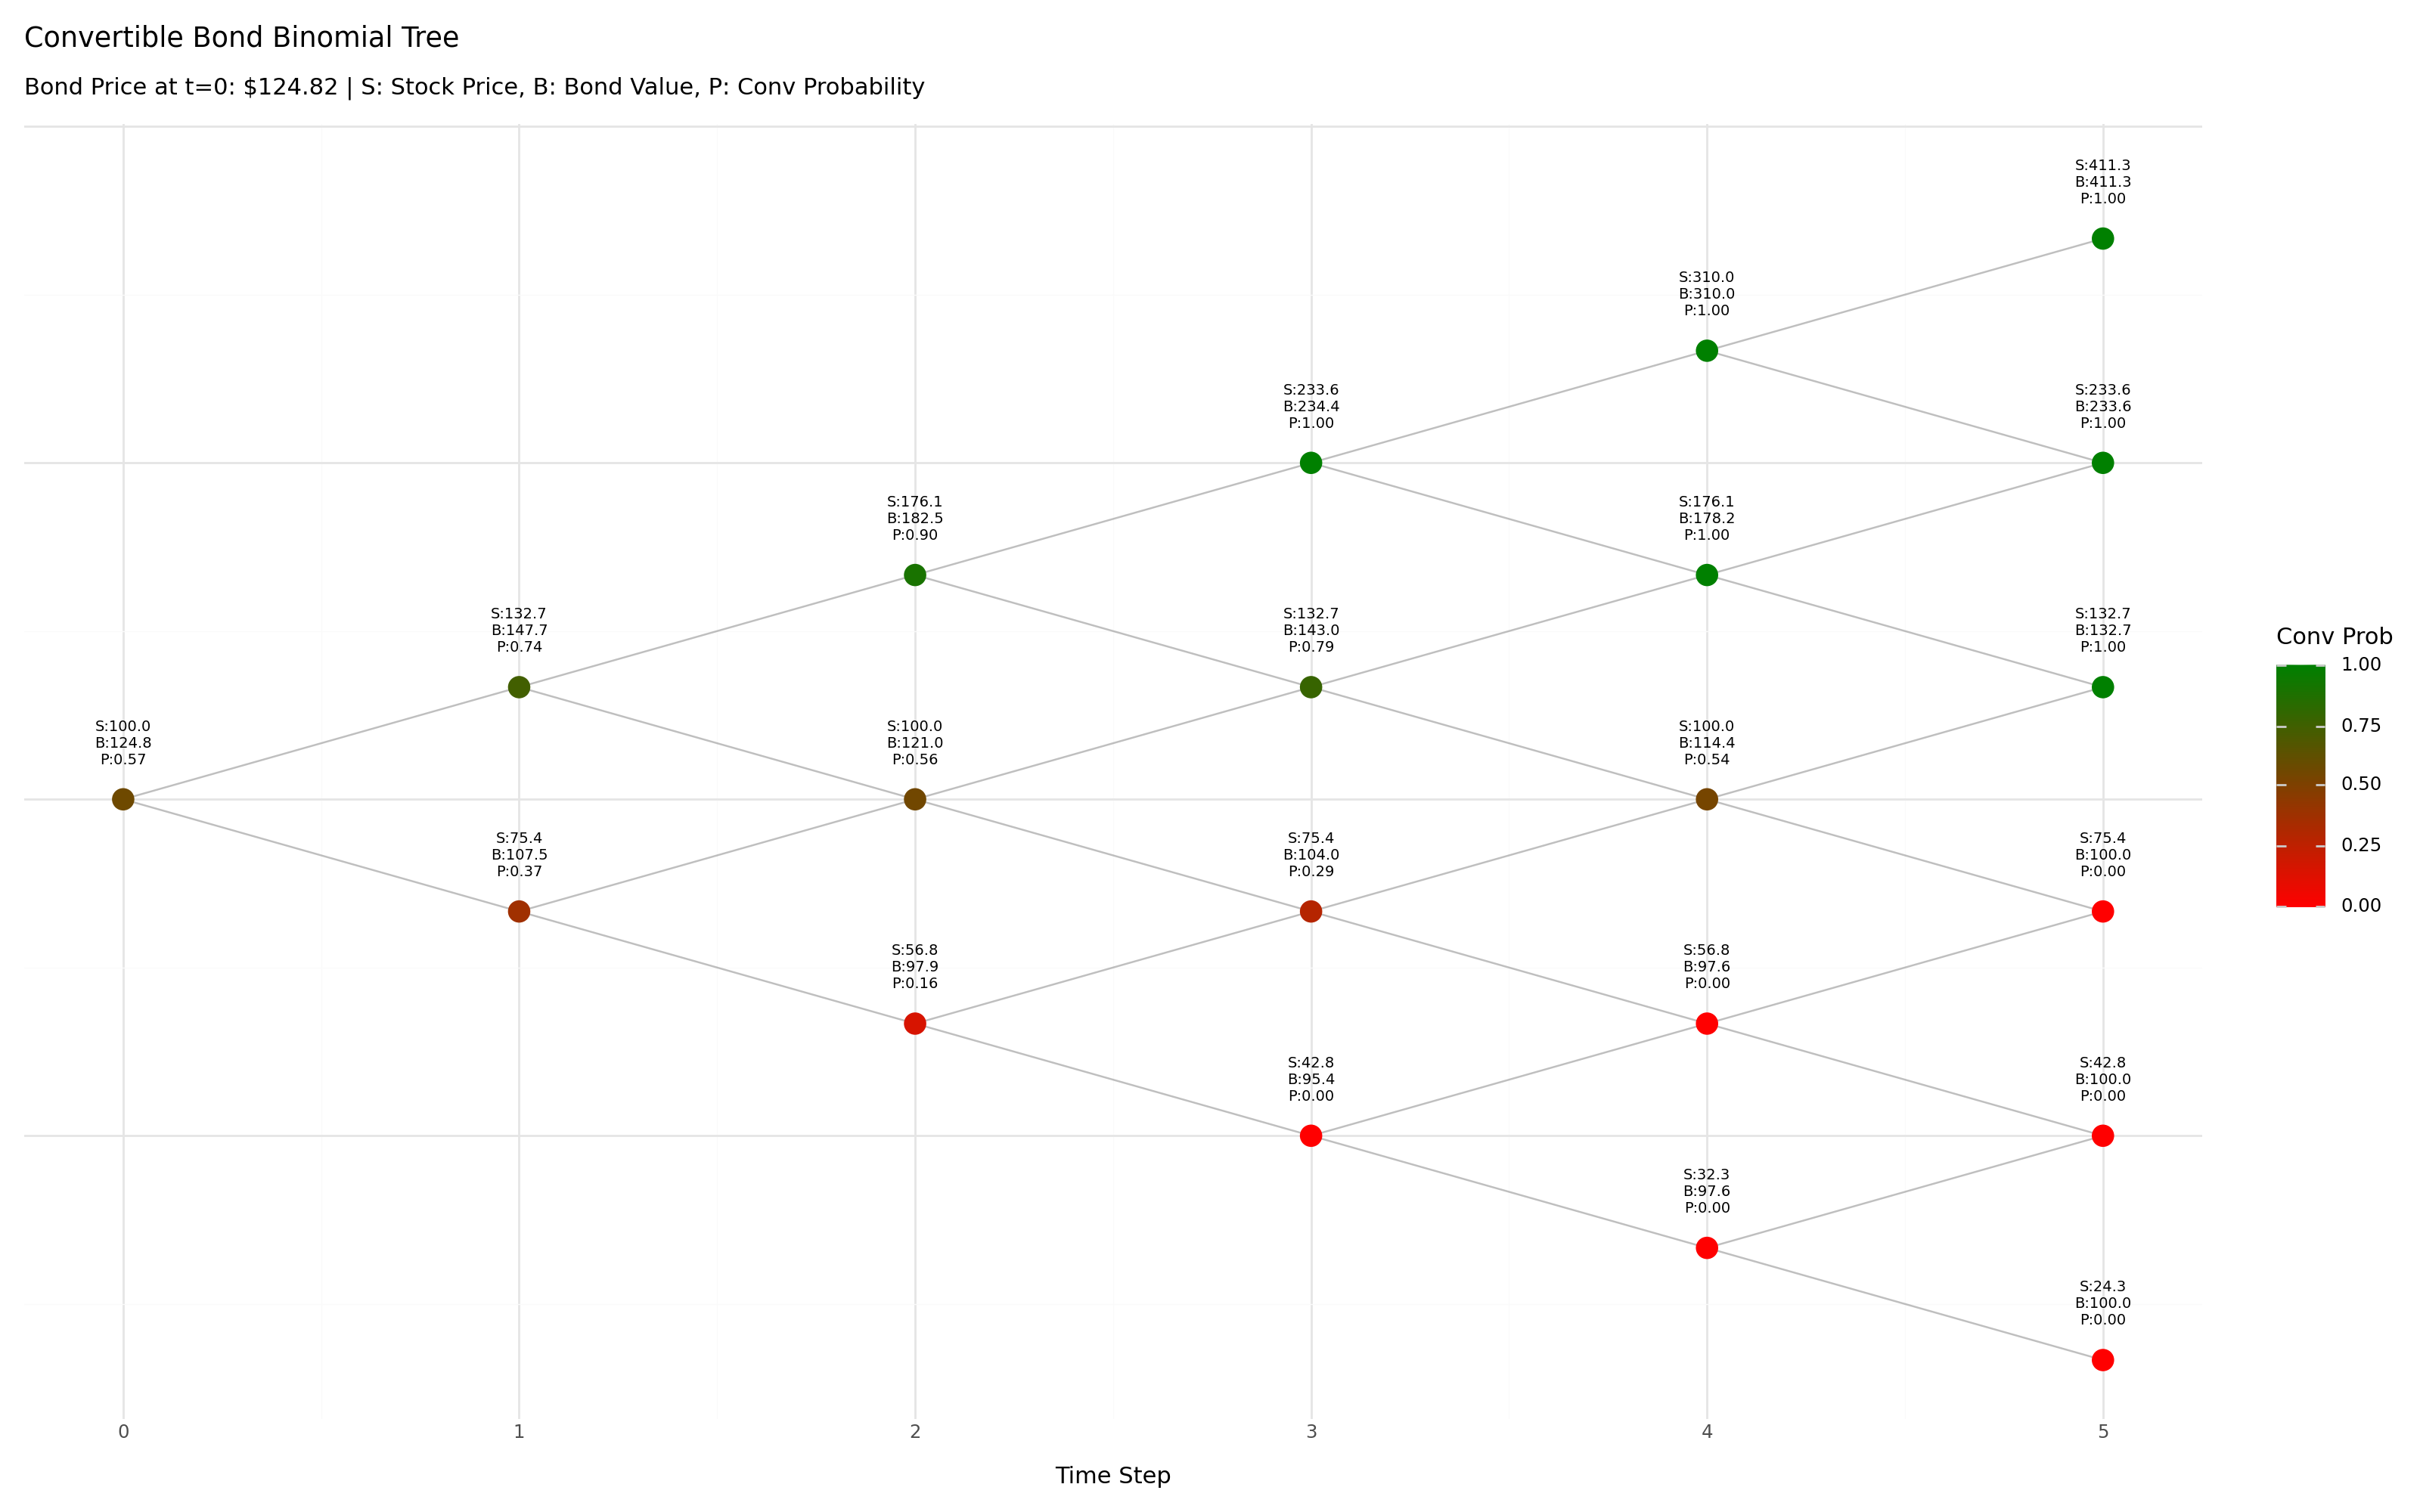

In [31]:
# Create the plot
plot = (
    ggplot() +
    geom_segment(data=df_edges, mapping=aes(x='x', y='y', xend='xend', yend='yend'), 
                 color='gray', alpha=0.5) +
    geom_point(data=df_tree, mapping=aes(x='time', y='y_pos', color='conv_prob'), 
               size=5) +
    scale_color_gradient(low='red', high='green', name='Conv Prob') +
    geom_text(data=df_tree, mapping=aes(x='time', y='y_pos', label='label'), 
              size=7, nudge_y=0.5) +
    labs(
        title='Convertible Bond Binomial Tree',
        x='Time Step',
        y='',
        subtitle=f'Bond Price at t=0: ${bond_value[0, 0]:.2f} | S: Stock Price, B: Bond Value, P: Conv Probability'
    ) +
    theme_minimal() +
    theme(
        axis_text_y=element_blank(),
        axis_ticks_y=element_blank(),
        figure_size=(16, 10)
    )
)

plot

In [28]:
print(f"\nConvertible Bond Price: ${bond_value[0, 0]:.2f}")
print(f"Conversion Probability at t=0: {conversion_prob[0, 0]:.4f}\n")


Convertible Bond Price: $124.82
Conversion Probability at t=0: 0.5703

